In [4]:
# Import necessary libraries
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import pandas as pd
from affine import Affine
import numpy as np
import rasterio as rio
import rasterio.plot
import pyepsg
from rasterio.warp import reproject, Resampling
import geopandas as gpd
import math

In [5]:
# Different component parts
# Land surface
# Bedrock surface
# Overburden thickness
# Wells
# Fractures
# Faults

In [6]:
# Land surface
# Use rasterio to read in raster and matplotlib to plot in plan view
elev = rio.open(r"Y:\EA_Geology\Projects\Other Projects & Reports\BenningtonPFOA\GIS Data\ArcGISPro_Scene\Benn_BlockDiagram\Benn_LiDAR_2012_BedrockExtent.tif")
rio.plot.show(elev, 1)

## Resample, if no resampleing desired comment out code or set adj_factor to 1.
arr = elev.read()

with rio.Env():
    
    adj_factor =  0.1 # Factor for change in resolution
    
    newarr = np.empty(shape=(arr.shape[0],  # same number of bands
                             round(arr.shape[1] * adj_factor), 
                             round(arr.shape[2] * adj_factor)))

    # adjust the new affine transform to cell size based on adj factor
    aff = elev.transform
    newaff = Affine(aff.a / adj_factor, aff.b, aff.c,
                    aff.d, aff.e / adj_factor, aff.f)
    
    reproject(
        arr, newarr,
        src_transform = aff,
        dst_transform = newaff,
        src_crs = elev.crs,
        dst_crs = elev.crs,
        resampling = Resampling.bilinear)
    
# Write to new raster
# Get raster attributes from elev raster and then change appropriate parameters (Affine, Height, Width)
meta = elev.profile
meta['transform'] = newaff
meta['height'] = newarr.shape[1]
meta['width'] =  newarr.shape[2]
# Not sure why but the datatype changed, going to change it back to float32
newarr = newarr.astype('float32')

with rio.open('Y:\EA_Geology\Projects\Other Projects & Reports\BenningtonPFOA\GIS Data\ArcGISPro_Scene\Benn_BlockDiagram\Benn_LiDAR_2012_BedrockExtent_res.tif', 'w', **meta) as dst:
    dst.write(newarr[0], 1)

# could also be done in memory possibly with from rasterio.io import MemoryFile? 

# Plot resampled raster
elev_res = rio.open(r"Y:\EA_Geology\Projects\Other Projects & Reports\BenningtonPFOA\GIS Data\ArcGISPro_Scene\Benn_BlockDiagram\Benn_LiDAR_2012_BedrockExtent_res.tif")
rio.plot.show(elev_res, 1)

# Build x,y,z for plotting
x = range(0, elev_res.width)
y = range(0, elev_res.height)

x_zip = list(zip(x, [0]*len(x)))
y_zip = list(zip([0]*len(y), y))

x_vals = [newaff*c for c in x_zip]
y_vals = [newaff*c for c in y_zip]

x_vals_only = [a[0] for a in x_vals]
y_vals_only = [a[1] for a in y_vals]

# Get z-array using .read() from rasterio.
z_array = elev_res.read()
z_array[z_array < 0] = np.nan

LandSurface = go.Surface(
        x = x_vals_only,
        y = y_vals_only,
        z = z_array[0],
        opacity = 0.6,
        showscale=False
        #need to change color ramp
    )

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

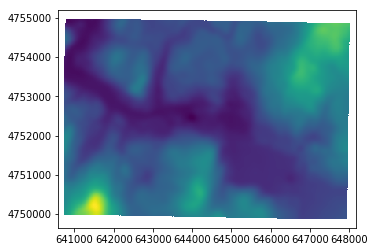

In [7]:
# Bedrock surface
bed_elev = rio.open(r"Y:\EA_Geology\Projects\Other Projects & Reports\BenningtonPFOA\GIS Data\ArcGISPro_Scene\Benn_BlockDiagram\Benn_BedSurf_BedrockExtent_Res20.tif")
rio.plot.show(bed_elev, 1)
bed_aff = bed_elev.transform

# Build x, y vectors and z-array for plotly
bed_x = range(0, bed_elev.width)
bed_y = range(0, bed_elev.height)

bed_x_zip = list(zip(bed_x, [0]*len(bed_x)))
bed_y_zip = list(zip([0]*len(bed_y), bed_y))

bed_x_vals = [bed_aff*c for c in bed_x_zip]
bed_y_vals = [bed_aff*c for c in bed_y_zip]

bed_x_vals_only = [a[0] for a in bed_x_vals]
bed_y_vals_only = [a[1] for a in bed_y_vals]

bed_z_array = bed_elev.read()

# Convert all values at raster edges to np.nan instead of -999
bed_z_array[bed_z_array < 0] = np.nan

BedrockSurface = go.Surface(
        x = bed_x_vals_only,
        y = bed_y_vals_only,
        z = bed_z_array[0],
        colorscale= 'Greys',
        showscale=False
        
    )

BedrockSurface_opacity = go.Surface(
        x = bed_x_vals_only,
        y = bed_y_vals_only,
        z = bed_z_array[0],
        colorscale= 'Greys',
        showscale=False,
        opacity = 0.2
        
    )

In [8]:
# Overburden Thickness
# This needs to be a 3D mesh defined by landSurface on top and Bedrock Surface on bottom

# Could also be a series of meshes (ie a top and bottom, then four sides)
# The side meshes could be obtained by just getting points along sides of the rasters?

In [9]:
# Faults as lines

# Next step is to add faults
# Points at surface -  Get X-Y values from the linestring, calculate Z - values at surface, sample raster
# Read in faults
faults = gpd.read_file(r"C:\Users\colin.dowey\OneDrive - State of Vermont\MyFiles\Python\BoreholePlots\Faults\Bennington_Thrust_Faults.shp")

fault_traces = []
offset_f = 1

for a in faults['geometry']:
    points = list(a.coords)
    
    # Get list of x and y
    x,y = map(list,zip(*points))
    z_fault = []
    # Need to sample bedrock raster to get z
    for val in bed_elev.sample(points): 
        z_fault.append(val[0] + offset_f)
        
    fault = go.Scatter3d(
        x=x, 
        y=y, 
        z=z_fault,
        marker=dict(
        size=0,
        colorscale='Viridis',
        opacity = 0.3
        ),
        line=dict(
            color='#1f77b4',
            width=6
            )
        )
    
    fault_traces.append(fault)

# Faults as planes
# At each point along the fault get the strike and dip(this is a constant). 
# calculate the equation of the plane through the point 
# then calculate z for x' and y' which equal x' = L*cos(angle in rad) and y = L*sin(angle in rad)

In [10]:
# Wells with Fractures

# Read in data to dataframe

bore_data = pd.read_excel(r"Y:\EA_Geology\Projects\Other Projects & Reports\BenningtonPFOA\geophysical well logging\structural data from wells\borehole tilt data\26STL-Azimuth-tilt.xlsx")

# Set Initial Well Position to Starting Depth, X = 0, Y = 0
bore_data.loc[0,'True Vertical Depth (m)'] = bore_data.loc[0,'Depth (m)']
bore_data.loc[0,'X (m)'] = 643483
bore_data.loc[0,'Y (m)'] = 4752949
well_elev = 197


# Iterate through dataframe and calculate True Vertical Depth, X, and Y for each set of borehole measurements

for i in range(1, len(bore_data)):
    bore_data.loc[i,'True Vertical Depth (m)'] = (bore_data.loc[(i - 1), 'True Vertical Depth (m)'] + ((bore_data.loc[i, 'Depth (m)'] - bore_data.loc[(i-1), 'Depth (m)'])*math.cos(math.radians(bore_data.loc[i, 'Tilt (°)']))))
    bore_data.loc[i, 'X (m)'] = (bore_data.loc[(i-1), 'X (m)']) + ((bore_data.loc[i, 'Depth (m)'] - bore_data.loc[(i-1), 'Depth (m)'])*(math.sin(math.radians(bore_data.loc[i, 'Tilt (°)'])))*(math.cos(math.radians(bore_data.loc[i, 'Azimuth (°)']))))
    bore_data.loc[i, 'Y (m)'] = (bore_data.loc[(i-1), 'Y (m)']) + ((bore_data.loc[i, 'Depth (m)'] - bore_data.loc[(i-1), 'Depth (m)'])*(math.sin(math.radians(bore_data.loc[i, 'Tilt (°)'])))*(math.sin(math.radians(bore_data.loc[i, 'Azimuth (°)']))))
   
# Convert depth to negative z
bore_data['True Vertical Depth (m)'] = bore_data['True Vertical Depth (m)'] * -1

# Convert depths to elevations
bore_data['True Vertical Depth (m)'] = [well_elev + x for x in bore_data['True Vertical Depth (m)']]

# Read in fracture data
fractures = pd.read_excel(r"Y:\EA_Geology\Projects\Other Projects & Reports\BenningtonPFOA\geophysical well logging\structural data from wells\borehole tilt data\26STL-Structures gte 60 degrees, E-W striking.xlsx")

# To get the well information where each fracture occurs I joined the bore_data dataframe and the fractures dataframe

bore_data = bore_data.sort_values(by='Depth (m)')
fractures = fractures.sort_values(by='Depth (m)')

# The join matches well data and fractures at the closest depth value

# I tuned the parameters on this pd.merge_asof but I then filter out any duplicates so a coarse match is fine
bf = pd.merge_asof(bore_data, fractures, left_on = 'Depth (m)', right_on = 'Depth (m)', direction = 'nearest', tolerance = 0.004, allow_exact_matches = True)
fract_xyz = bf[bf['Spacing (ft)'].notnull()].copy()
fract_xyz.drop_duplicates(subset ="Spacing (ft)", keep = 'first', inplace = True)

def plane_coordinates(strike, dip, x, y, z):
    # Convert to radians
    strike_rad = math.radians(strike)
    dip_rad = math.radians(dip)
    
    # Calculate coeffecients for equation of a plane
    a = -1*math.sin(dip_rad)*math.cos(strike_rad)
    b = math.sin(dip_rad)*math.sin(strike_rad)
    c = -1*math.cos(dip_rad)
    
    d = -1*(a*(x) + b*(y) + c*(z))
    
    # Calculate Z for four points 1 unit away from given point in x and y directions
    
    x_vect = np.array([x - 10, x + 10])
    y_vect = np.array([y - 10, y + 10])
    z_array = np.empty(shape = (2,2))
    
    z_array[0,0] = (0 - (a*(x_vect[0]) + b*(y_vect[0])) - d)/(c)
    z_array[0,1] = (0 - (a*(x_vect[1]) + b*(y_vect[0])) - d)/(c)
    z_array[1,0] = (0 - (a*(x_vect[0]) + b*(y_vect[1])) - d)/(c)
    z_array[1,1] = (0 - (a*(x_vect[1]) + b*(y_vect[1])) - d)/(c)
    
    return x_vect, y_vect, z_array

# Calculate x, y vectors and z-array for each fracture in fract_xyz
fract_xyz['xyz_vectors'] = fract_xyz.apply(lambda x: plane_coordinates(x['Strike \n(°)'], x['Dip \n(°)'], x['X (m)'], x['Y (m)'], x['True Vertical Depth (m)']  ), axis=1)

# In order to plot these in x, y, z space along with other datasets an across the board, x, y and z offset is applied

# Boring
#well_x = 643306
#well_y = 4752496
#landsurfelev = 166

#bore_data['X (m)'] = [x + well_x for x in bore_data['X (m)']]
#bore_data['Y (m)'] = [y + well_y for y in bore_data['Y (m)']]
#bore_data['True Vertical Elevation (m)'] = [landsurfelev - z for z in bore_data['True Vertical Depth (m)']]

# Points where well intersetcts
#fract_xyz['X (m)'] = [x + well_x for x in fract_xyz['X (m)']]
#fract_xyz['Y (m)'] = [y + well_y for y in fract_xyz['Y (m)']]
#fract_xyz['True Vertical Elevation (m)'] = [landsurfelev - z for z in fract_xyz['True Vertical Depth (m)']]

# Create traces
well = go.Scatter3d(
    x = bore_data['X (m)'], 
    y = bore_data['Y (m)'], 
    z = bore_data['True Vertical Depth (m)'],
    mode='markers',
    marker={
        'size': 2,
        'opacity': 0.8,
        'color' : bore_data['Tilt (°)'],
       # 'colorbar' : dict(title='Tilt (°)', tickmode = 'linear', tick0 = 0, dtick = 1),
        'colorscale' : 'JET'
    },
    showlegend = False
)

# Construct trace for plotting where fractures intersect well, colored by dip
well_fract_int = go.Scatter3d(
    x = fract_xyz['X (m)'], 
    y = fract_xyz['Y (m)'], 
    z = fract_xyz['True Vertical Depth (m)'],
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.8,
        'color' : fract_xyz['Dip \n(°)'],
       # 'colorbar' : dict(title = 'Dip (°)', xpad = 200, tickmode = 'linear', tick0 = 60, dtick = 5),
        'colorscale' : 'Greens',
        'reversescale' : True
    },
    showlegend = False
)

# Construct fracture surfaces as planes

fracture_surfaces = []

for surface in fract_xyz['xyz_vectors']:
    fract_surf = go.Surface(
    x = surface[0],
    y = surface[1],
    z = surface[2],
    surfacecolor = ['rgb(100, 100, 100)', 'rgb(100, 100, 100)'],
   # showscale = False,
  #  showlegend = False,
    opacity = 0.3
)
        
    fracture_surfaces.append(fract_surf)

In [11]:
# PLot 379HR well

# Read in data to dataframe

bore_data = pd.read_excel(r"Y:\EA_Geology\Projects\Other Projects & Reports\BenningtonPFOA\geophysical well logging\structural data from wells\borehole tilt data\379HR-Azimuth-tilt.xlsx")

# Set Initial Well Position to Starting Depth, X = 0, Y = 0
bore_data.loc[0,'True Vertical Depth (m)'] = bore_data.loc[0,'Depth (m)']
bore_data.loc[0,'X (m)'] = 642286
bore_data.loc[0,'Y (m)'] = 4753197
well_elev = 201


# Iterate through dataframe and calculate True Vertical Depth, X, and Y for each set of borehole measurements

for i in range(1, len(bore_data)):
    bore_data.loc[i,'True Vertical Depth (m)'] = (bore_data.loc[(i - 1), 'True Vertical Depth (m)'] + ((bore_data.loc[i, 'Depth (m)'] - bore_data.loc[(i-1), 'Depth (m)'])*math.cos(math.radians(bore_data.loc[i, 'Tilt (°)']))))
    bore_data.loc[i, 'X (m)'] = (bore_data.loc[(i-1), 'X (m)']) + ((bore_data.loc[i, 'Depth (m)'] - bore_data.loc[(i-1), 'Depth (m)'])*(math.sin(math.radians(bore_data.loc[i, 'Tilt (°)'])))*(math.cos(math.radians(bore_data.loc[i, 'Azimuth (°)']))))
    bore_data.loc[i, 'Y (m)'] = (bore_data.loc[(i-1), 'Y (m)']) + ((bore_data.loc[i, 'Depth (m)'] - bore_data.loc[(i-1), 'Depth (m)'])*(math.sin(math.radians(bore_data.loc[i, 'Tilt (°)'])))*(math.sin(math.radians(bore_data.loc[i, 'Azimuth (°)']))))
   
# Convert depth to negative z
bore_data['True Vertical Depth (m)'] = bore_data['True Vertical Depth (m)'] * -1

# Convert depths to elevations
bore_data['True Vertical Depth (m)'] = [well_elev + x for x in bore_data['True Vertical Depth (m)']]

# Create traces
well2 = go.Scatter3d(
    x = bore_data['X (m)'], 
    y = bore_data['Y (m)'], 
    z = bore_data['True Vertical Depth (m)'],
    mode='markers',
    marker={
        'size': 2,
        'opacity': 0.8,
        'color' : bore_data['Tilt (°)'],
       # 'colorbar' : dict(title='Tilt (°)', tickmode = 'linear', tick0 = 0, dtick = 1),
        'colorscale' : 'JET'
    },
    showlegend = False
)

In [12]:
# 

In [13]:
# Create list of data to plot
data = []
data.append(LandSurface)
data.append(BedrockSurface)
data = data + fault_traces
data.append(well)
data.append(well_fract_int)
data = data + fracture_surfaces
data.append(well2)
data.append(BedrockSurface_opacity)

#data = [LandSurface, BedrockSurface, well, well_fract_int, well2]
#data = data + fault_traces + fracture_surfaces

In [14]:
all_vis = [True] * len(data)
#Land
land = all_vis.copy()
land[1:] = [False] * len(land[1:])

#Bed
bed = all_vis.copy()
bed[2:] = [False] * len(bed[1:])
bed[0] = False

#Land and Bed
land_bed = all_vis.copy()
land_bed[2:] = [False] * len(land_bed[2:])

#Bedrock and Fault
bed_fault = all_vis.copy()
bed_fault[2:] = [False] * len(bed_fault[2:])
bed_fault[0] = False
bed_fault[2:6] = [True] * len(bed_fault[2:6])   # fault traces somehow has four lines???

# Well Bores
bed_well_bore = all_vis.copy()
bed_well_bore[0:] = [False] * len(bed_well_bore[0:])
bed_well_bore[2:7] = [True] * len(bed_fault[2:7])
bed_well_bore[7] = True
bed_well_bore[40] = True
bed_well_bore[41] = True


# Well Bores and fractures
bed_well_fract = bed_well_bore.copy()
bed_well_fract[8:39] = [True] * len(bed_well_fract[8:39])

In [15]:
bed_well_fract

[False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True]

In [16]:
# Create Buttons
updatemenus = list([
    dict(type="buttons",
         active=-1,
         buttons=list([
            dict(label = 'All Layers',
                 method = 'update',
                 args = [{'visible': all_vis},
                         {'title': 'All Layers'}]),
             
            dict(label = 'Land Surface',
                 method = 'update',
                 args = [{'visible': land},
                         {'title': 'Land Surface'}]),
             
            dict(label = 'Bedrock Surface',
                 method = 'update',
                 args = [{'visible': bed},
                         {'title': 'Bedrock Surface'}]),
             
            dict(label = 'Land + Bedrock Surface',
                 method = 'update',
                 args = [{'visible': land_bed},
                         {'title': 'Land + Bedrock Surfaces'}]), 
             
            dict(label = 'Bedrock Surface + Fault Trace',
                 method = 'update',
                 args = [{'visible': bed_fault},
                         {'title': 'Bedrock Surfaces + Fault Traces'}]), 
             
            dict(label = 'Bedrock Surface + Fault Trace + Well Bore',
                 method = 'update',
                 args = [{'visible': bed_well_bore},
                         {'title': 'Bedrock Surfaces + Fault Traces + Well Bores'}]),
             dict(label = 'Bedrock Surface + Fault Trace + Well Bore + Fractures',
                 method = 'update',
                 args = [{'visible': bed_well_fract},
                         {'title': 'Bedrock Surfaces + Fault Traces + Well Bores + Fractures'}])
            
        ]),
    )
    ])

In [23]:
# Create Plot Layout and Camera
layout = go.Layout(
    title='BennLiDAR',
    autosize=True,
    width=1500,
    height=700,
    showlegend=False,
    updatemenus=updatemenus,
    scene = dict(
           xaxis=dict(),
           yaxis=dict(),
           zaxis=dict(),
           aspectmode='manual', # this can be 'data', 'cube', 'auto', 'manual'
           # custom aspect ratio
           aspectratio=dict(x=1, y=1, z=0.1)
           )
    )

In [24]:
# Plot
plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
init_notebook_mode(connected=True)
#plotly.offline.iplot(plot_figure)
plotly.offline.plot(plot_figure,)

'temp-plot.html'